In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import numpy as np
import random
import cv2
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import *
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt

In [ ]:
#Set up collab
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
dir_images='/content/drive/MyDrive/datasets/training/images/'
dir_mask  ='/content/drive/MyDrive/datasets/training/1st_manual/'

# Define augmentation Functions

In [ ]:
def rotateImage(image, angle):
    image_center = tuple(np.array(image.shape[1::-1])/2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags = cv2.INTER_LINEAR)
    return result

def bruit(image):
    h, w, c = image.shape
    n = np.random.randn(h, w, c)*random.randint(5, 30)
    return np.clip(image+n, 0, 255).astype(np.uint8)

def change_gamma(image, alpha=1.0, beta=0.0):
    return np.clip(alpha*image+beta, 0, 255).astype(np.uint8)

def color(image, alpha=20):
    n = [random.randint(-alpha, alpha), random.randint(-alpha, alpha),random.randint(-alpha, alpha)]
    return np.clip(image+n, 0, 255).astype(np.uint8)

#randomly apply augmentation
def random_change(image):
    if np.random.randint(2):
        img = change_gamma(image, random.uniform(0.8, 1.2), np.random.randint(100)-50)
    if np.random.randint(2):
        img = bruit(image)
    if np.random.randint(2):
        img = color(image)
    return image

# Apply augmentation

In [ ]:
tab_images = []
tab_masks = []

list_file = os.listdir(dir_images)
if list_file is None:
    quit("No file in {} !".format(dir_images))
    
for fichier in list_file:
    img_orig = cv2.imread(dir_images+fichier)
    
    tab_images.append(img_orig[:576, :560])
    num = fichier.split('_')[0]
    file_mask = dir_mask+num+'_manual1.gif'
    if not os.path.isfile(file_mask):
        quit("Mask of {} doesn't exist in {}".format(file_mask, dir_mask))
    img_mask_orig = np.array(Image.open(file_mask))
    tab_masks.append(img_mask_orig[:576, :560])

    #Rotate image by 30° step until reaching 360° 
    #Apply random augmentation at each step for different flip
    for angle in range(0, 360, 30):
        img_r = rotateImage(img_orig, angle)
        img = img_r.copy()
        img = random_change(img)
        tab_images.append(img[:576, :560])
        img_mask = rotateImage(img_mask_orig, angle)
        tab_masks.append(img_mask[:576, :560])
        
        #flip around x-axes
        img = cv2.flip(img_r, 0)
        img = random_change(img)
        tab_images.append(img[:576, :560])
        img_m = cv2.flip(img_mask, 0)
        tab_masks.append(img_m[:576, :560])

        #flip around y-axes
        img = cv2.flip(img_r, 1)
        img = random_change(img)
        tab_images.append(img[:576, :560])
        img_m = cv2.flip(img_mask, 1)
        tab_masks.append(img_m[:576, :560])

        #flip around x and y axes
        img = cv2.flip(img_r, -1)
        img = random_change(img)
        tab_images.append(img[:576, :560])
        img_m = cv2.flip(img_mask, -1)
        tab_masks.append(img_m[:576, :560])

In [ ]:
tab_images=np.array(tab_images, dtype=np.float32)/255
tab_masks =np.array(tab_masks,  dtype=np.float32)[:, :, :]/255
train_images, test_images, train_masks, test_masks=train_test_split(tab_images, tab_masks, test_size=0.05)

#del some data to reduce the load on our poor infrastructure
del tab_images
del tab_masks

# Define double Unet

![](https://i.ibb.co/KyXDQwV/Double-U-Net.png)

In [ ]:
# "Squeeze-and-Excitation Networks" https://arxiv.org/pdf/1709.01507.pdf
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

# Create convolution block = 2 convolution layers with same filters
def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

# Create encoder /decoder
# First encoder use pretrained VGG19
def encoder1(inputs):
    connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    #Assign names to VGG19 blocks and store them in 'connections'
    #to connect them with corresponding blocks in decoder
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, connections

def decoder1(inputs, connections):
    num_filters = [256, 128, 64, 32]
    #Reverse the connections list, to start by the last encoder block
    connections.reverse()
    x = inputs
    shape = x.shape

    for i, f in enumerate(num_filters):
        x = Conv2DTranspose(shape[3], (2, 2), activation="relu", strides=(2, 2))(x)
        #Create connection with encoder
        x = Concatenate()([x, connections[i]])
        x = conv_block(x, f)
    return x

# Create second Unet in the same way

def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, connections

def decoder2(inputs, connections_1, connections_2):
    num_filters = [256, 128, 64, 32]
    connections_2.reverse()
    x = inputs
    shape = x.shape

    for i, f in enumerate(num_filters):
        x = Conv2DTranspose(shape[3], (2, 2), activation="relu", strides=(2, 2))(x)
        x = Concatenate()([x, connections_1[i], connections_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

#Atrous SpatialPyramid Pooling
# "Rethinking Atrous Convolution for Semantic Image Segmentation" https://arxiv.org/pdf/1706.05587.pdf
def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    shape2 = y1.shape
    
    y1 = Conv2DTranspose(shape2[3], (8,8), activation="relu", strides=(shape[1], shape[2]))(y1)
    

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

In [ ]:
def build_model():
    #First Unet
    inputs = Input((576, 560, 3))
    x, connections_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, connections_1)
    outputs1 = output_block(x)

    #Multiply outpout of first Unet by input
    x = inputs * outputs1

    #Second Unet
    x, connections_2 = encoder2(x)
    x = ASPP(x, 64)
    #Second Unet decoder use connection from encoder 1 and 2 
    x = decoder2(x, connections_1, connections_2)
    outputs2 = output_block(x)

    #Concatenate output of both Unet
    outputs = Concatenate()([outputs1, outputs2])
    
    combine_output = Conv2D(1, (64,64), activation="sigmoid", padding="same")(outputs)

    model = Model(inputs, combine_output)
    return model



Metrics

In [ ]:
def dice_coeff(y_true, y_pred):
    _epsilon = 10 ** -7
    intersections = tf.reduce_sum(y_true * y_pred)
    unions = tf.reduce_sum(y_true + y_pred)
    dice_scores = (2.0 * intersections + _epsilon) / (unions + _epsilon)
    return dice_scores

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [ ]:
my_model = build_model()

metrics = [
    dice_coeff,
    #jaccard_distance_loss,
    #bce_dice_loss,
    Recall(),
    Precision(),
    AUC()
]

callbacks = [
    ModelCheckpoint('/content/drive/MyDrive/datasets/double_unet.h5', verbose=1,
                        save_best_only=True, save_weights_only=True, monitor='val_auc', mode='max'),
    #Reduce learning rate when a metric has stopped improving
    ReduceLROnPlateau(monitor='val_auc', factor=0.1, patience=5)
]

my_model.compile(optimizer = Adam(lr = 1e-3),
                  loss = bce_dice_loss, 
                  metrics = metrics)

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
# Train the model
#my_model.fit(train_images,
            train_masks,
            epochs=30,
            batch_size=4,
            validation_data=(test_images, test_masks),
            callbacks=callbacks)

Epoch 1/30
233/233 [==============================] - 3055s 8s/step - loss: 0.9160 - dice_coeff: 0.3383 - recall: 0.3242 - precision: 0.5178 - auc: 0.8025 - val_loss: 0.5117 - val_dice_coeff: 0.6289 - val_recall: 0.5880 - val_precision: 0.8522 - val_auc: 0.9398

Epoch 00001: val_auc improved from -inf to 0.93981, saving model to /content/drive/MyDrive/datasets/double_unet.h5
Epoch 2/30
233/233 [==============================] - 588s 3s/step - loss: 0.4111 - dice_coeff: 0.7058 - recall: 0.6784 - precision: 0.8752 - auc: 0.9571 - val_loss: 0.4716 - val_dice_coeff: 0.6738 - val_recall: 0.4818 - val_precision: 0.9653 - val_auc: 0.9258

Epoch 00002: val_auc did not improve from 0.93981
Epoch 3/30
233/233 [==============================] - 587s 3s/step - loss: 0.3639 - dice_coeff: 0.7432 - recall: 0.6925 - precision: 0.9002 - auc: 0.9626 - val_loss: 0.3469 - val_dice_coeff: 0.7551 - val_recall: 0.7273 - val_precision: 0.8965 - val_auc: 0.9684

Epoch 00003: val_auc improved from 0.93981 to 0.

In [ ]:
my_model.load_weights('/content/drive/MyDrive/datasets/double_unet.h5')

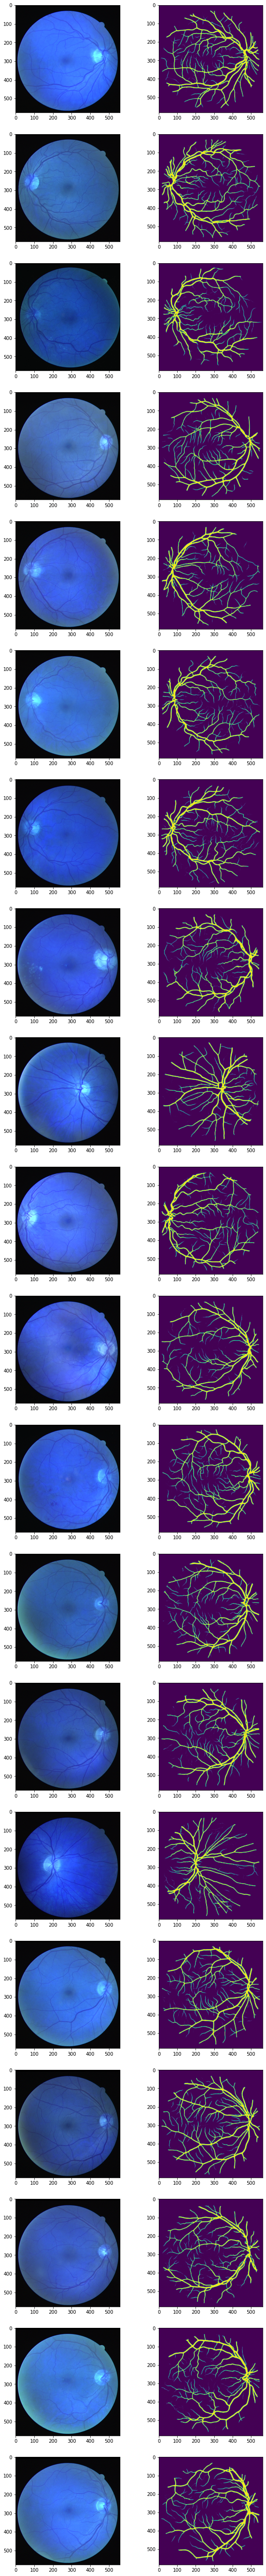

In [ ]:
fig, ax = plt.subplots(20,2,figsize=(10,100))
dir_test_images='/content/drive/MyDrive/datasets/test/images/'

tab_test_images=[]
tab_files=[]
for fichier in os.listdir(dir_test_images):
    img=cv2.imread(dir_test_images+fichier)
    tab_test_images.append(img[:576, :560])
    tab_files.append(fichier.split('_')[0])

tab_test_images=np.array(tab_test_images, dtype=np.float32)/255
tab_files=np.array(tab_files)


for id in range(len(tab_test_images)):
    mask=np.zeros((584, 565, 1), dtype=np.float32)
    prediction=my_model.predict(np.array([tab_test_images[id]]))
    mask[:576, :560]=prediction[0]*255
    mask = np.squeeze(mask)

    ax[id, 0].imshow(tab_test_images[id])
    ax[id, 1].imshow(mask)

    cv2.imwrite("/content/drive/MyDrive/datasets/double_Unet_pred/"+str(tab_files[id])+".png", mask)

fig.show()

Test on the STARE dataset
https://cecas.clemson.edu/~ahoover/stare/probing/index.html

In [ ]:
dir_images = '/content/drive/MyDrive/STARE/images/'
dir_mask = '/content/drive/MyDrive/STARE/label/'

tab_images=[]
tab_masks=[]

list_file=os.listdir(dir_images)
if list_file is None:
    quit("No file in {} !".format(dir_images))
    
for fichier in list_file:
    img_orig=cv2.imread(dir_images+fichier)
    
    tab_images.append(img_orig[:576, :560])
    num=fichier.split('.')[0]
    file_mask=dir_mask+num +'.ah.ppm'
    if not os.path.isfile(file_mask):
        quit("Mask of {} doesn't exist in {}".format(file_mask, dir_mask))
    img_mask_orig=np.array(Image.open(file_mask))
    tab_masks.append(img_mask_orig[:576, :560])

tab_images=np.array(tab_images, dtype=np.float32)/255
tab_masks =np.array(tab_masks,  dtype=np.float32)[:, :, :]/255
_ = my_model.evaluate(tab_images, tab_masks, verbose = 2, batch_size = 3)

7/7 - 251s - loss: 0.4093 - dice_coeff: 0.7191 - recall: 0.8394 - precision: 0.7141 - auc: 0.9630
